# Prepare some things
## Load some modules

In [1]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from scipy.cluster import hierarchy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../')
from clustering_metrics import evaluate_clustering
from draw_embeddings import draw_multiple_labels

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load the metabolomic data
(alrady min-max normalized)

In [4]:
metabol_exprs = pd.read_csv("../ExposomeChallengeData/datasets/metabol_joint_exprs_minmax.csv", index_col=0)
metabol_exprs.head()

serum_metab_1  serum_metab_2  serum_metab_3  serum_metab_4  \
430        0.224542       0.205024       0.490470       0.653163   
1187       0.402503       0.549489       0.828354       0.323912   
940        0.402503       0.556896       0.706195       0.534558   
936        0.462293       0.578889       0.451112       0.448921   
788        0.247137       0.571595       0.568414       0.417697   

      serum_metab_5  serum_metab_6  serum_metab_7  serum_metab_8  \
430        0.515652       0.483009       0.249523       0.340524   
1187       0.431621       0.491824       0.376192       0.348330   
940        0.544173       0.514375       0.397976       0.856991   
936        0.492050       0.553183       0.372429       0.544806   
788        0.432269       0.553183       0.531642       0.534388   

      serum_metab_9  serum_metab_10  ...  urine_metab_35  urine_metab_36  \
430        0.400406        0.574663  ...        0.485001        0.628204   
1187       0.213731        0.308797  ...        0.469040        0.816605   
940        0.358113        0.315096  ...        0.469738        0.627037   
936        0.388943        0.545676  ...        0.457602        0.738061   
788        0.536561        0.704749  ...        0.452021        0.639165   

      urine_metab_37  urine_metab_38  urine_metab_39  urine_metab_40  \
430         0.489431        0.640612        0.391376        0.665946   
1187        0.441328        0.000000        0.494475        0.696170   
940         0.519383        0.000000        0.326659        0.645060   
936         0.290234        0.177238        0.451808        0.487007   
788         0.329798        0.354477        0.250210        0.702331   

      urine_metab_41  urine_metab_42  urine_metab_43  urine_metab_44  
430         0.848047        0.360177        0.587031        0.605114  
1187        0.413698        0.396026        0.572658        0.619732  
940         0.841829        0.000000        0.653218        0.665950  
936         0.759121        0.000000        0.678092        0.729031  
788         0.778121        0.345500        0.554585        0.661642  

[5 rows x 221 columns]

In [5]:
print("Shape of the data set:", metabol_exprs.shape)
print("Number of data points:", np.multiply(*metabol_exprs.shape))

Shape of the data set: (1152, 221)
Number of data points: 254592


## Load the categorical variables
(subset of phenotype and covariates data, already codified)

In [6]:
phenotype_cat = pd.read_csv("../ExposomeChallengeData/datasets/phenotype_cat.csv", index_col=0)
covariates_cat = pd.read_csv("../ExposomeChallengeData/datasets/covariates_cat.csv", index_col=0)
classes = pd.concat([phenotype_cat, covariates_cat], axis=1)
classes.head()

birth_weight  iq  behaviour  asthma  bmi  cohort  age  sex  education  \
1             3   0          3       0    1       3    1    0          1   
2             3   1          3       0    1       3    2    0          2   
3             3   0          3       1    3       3    1    0          2   
4             1   2          3       0    1       1    4    1          0   
5             3   0          1       0    1       2    4    0          0   

   native  parity  
1       2       0  
2       2       1  
3       2       1  
4       2       1  
5       2       0

In [7]:
print("Number of class variables:", classes.shape[1])

Number of class variables: 11


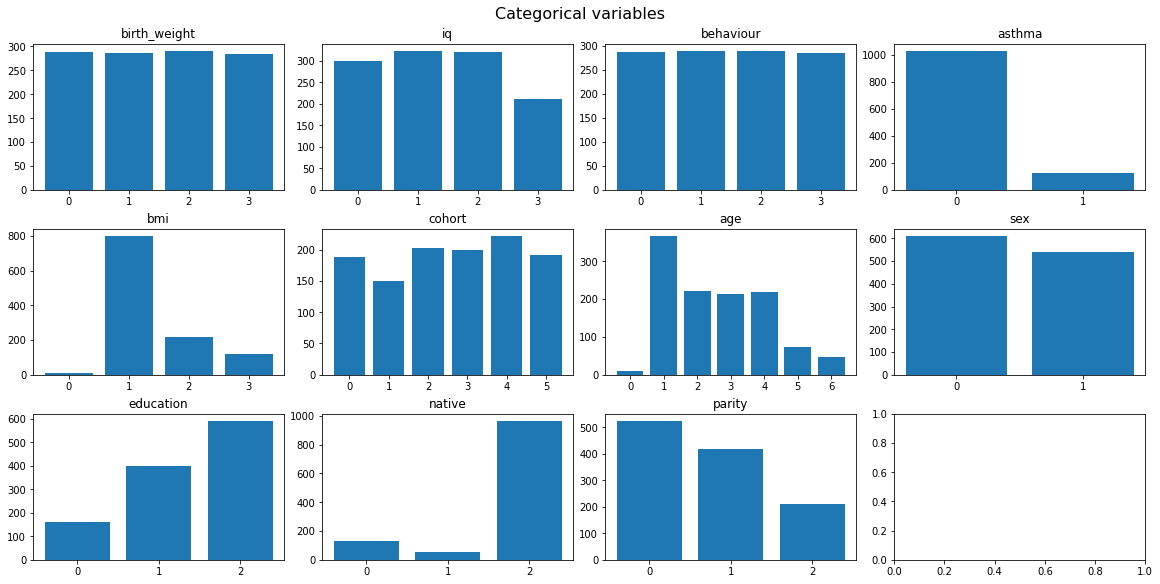

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8), constrained_layout=True)
i = 0
for axs in axes:
    for ax in axs:
        counts = classes.iloc[:,i].value_counts()
        index = counts.index
        ax.bar(index, counts)
        ax.set_xticks(index)
        ax.title.set_text(classes.columns[i])
        i += 1
        if i == classes.shape[1]:
            break
fig.suptitle("Categorical variables", fontsize=16)
plt.show()

# Raw data

## K-means


Try fitting K-means with a range of clusters. Compute the silhouette as a metric of QC. Plot the results.

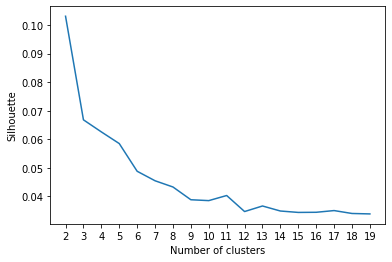

In [9]:
MIN_K = 2
MAX_K = 20

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(metabol_exprs)
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

The best result is achieved with K=2.

The categorical data has between 2 and 7 classes. I'll fix K to each number of classes and compare the clusters with the true labels to see if they match.

I'll plot a 2D representation of the data using the t-SNE transformacion with two components.

In [9]:
tsne = TSNE(n_components=2, init='pca')
raw_data_tsne = tsne.fit_transform(metabol_exprs)

In [10]:
categorical_variables = {2: ["asthma", "sex"],
                         3: ["education", "native", "parity"],
                         4: ["birth_weight", "iq", "behaviour"],
                         6: ["cohort"],
                         7: ["age"]}
true_labels = {}
for k, variables in categorical_variables.items():
    true_labels[k] = {var: classes.loc[:,var] for var in variables}
                
cluster_labels = []
results = []

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.103']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.103']
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.066']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.066']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.066']
birth_weight ['Acc: 0.267', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.063']
iq ['Acc: 0.297', 'ARI: -0.000', 'AMI: -0.000', 'Sil: 0.063']
behaviour ['Acc: 0.271', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.063']
cohort ['Acc: 0.214', 'ARI: 0.003', 'AMI: 0.002', 'Sil: 0.047']
age ['Acc: 0.319', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.046']


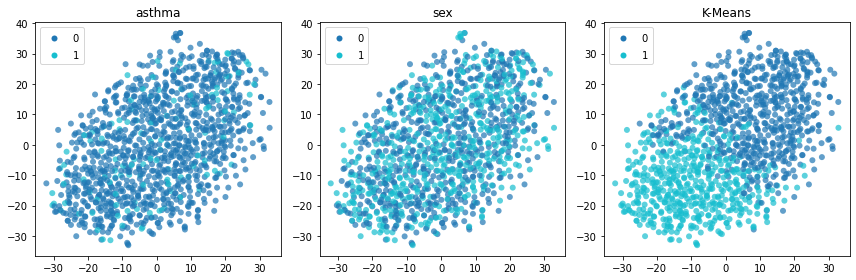

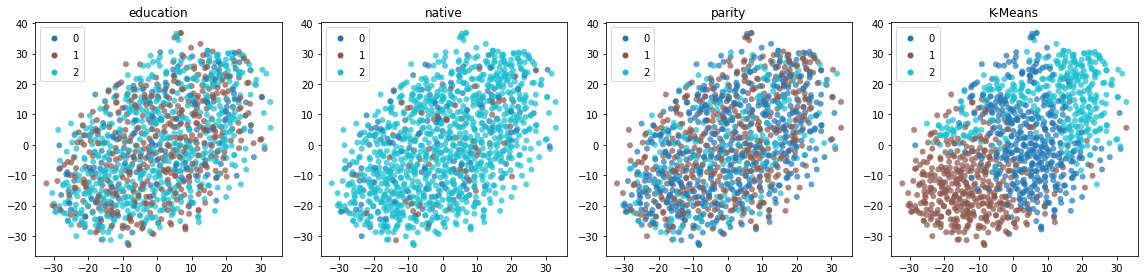

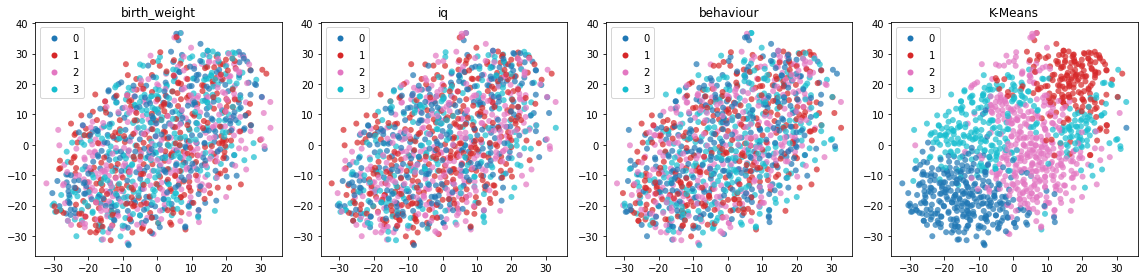

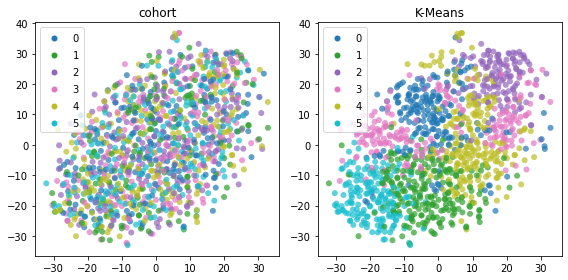

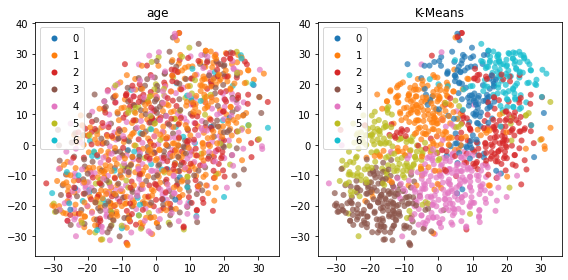

In [11]:
rl_method = "Raw data"
clust_method = "K-Means"
data = metabol_exprs
tsne_data = raw_data_tsne

for k in categorical_variables.keys():
    # Compute cluster assignments
    kmeans = KMeans(n_clusters=k, n_init=30)
    cluster_labels_ = kmeans.fit_predict(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})

    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

## GMM

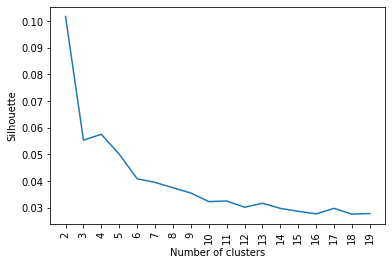

In [13]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=30)
    labels = gmm.fit_predict(metabol_exprs)
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.102']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.102']
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.057']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.057']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.057']
birth_weight ['Acc: 0.271', 'ARI: -0.000', 'AMI: -0.000', 'Sil: 0.057']
iq ['Acc: 0.299', 'ARI: -0.001', 'AMI: 0.001', 'Sil: 0.057']
behaviour ['Acc: 0.269', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.057']
cohort ['Acc: 0.216', 'ARI: 0.001', 'AMI: 0.001', 'Sil: 0.043']
age ['Acc: 0.319', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.041']


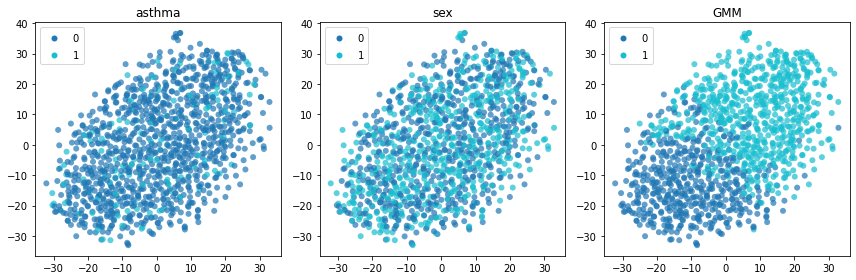

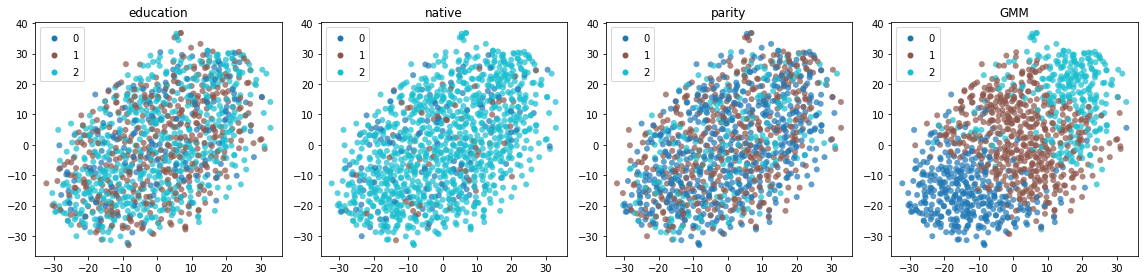

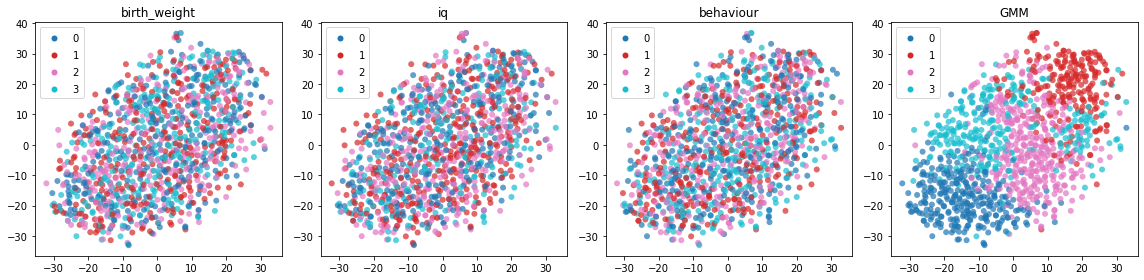

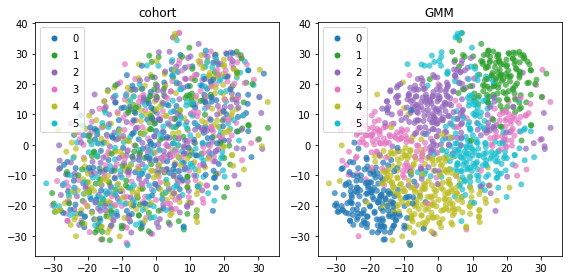

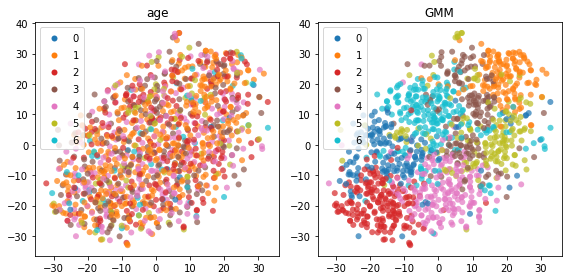

In [12]:
clust_method = "GMM"

for k in categorical_variables.keys():
    # Compute cluster assignments
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=30)
    cluster_labels_ = gmm.fit_predict(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})
    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable} 
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

## Agglomerative

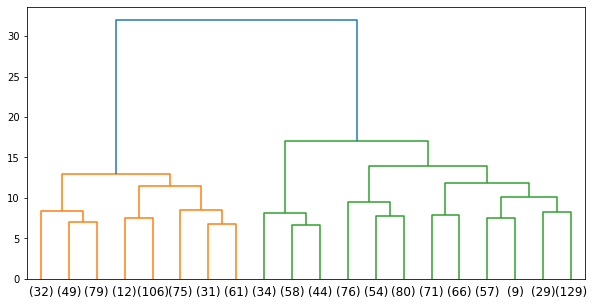

In [13]:
hier = hierarchy.linkage(metabol_exprs, method='ward', metric="euclidean")

plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z=hier, p=20, truncate_mode='lastp')
plt.show()

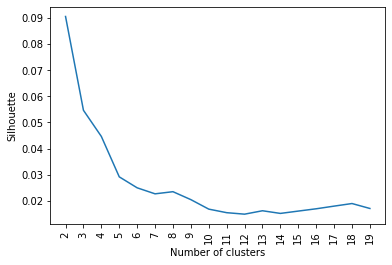

In [16]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    labels = hierarchy.cut_tree(hier, n_clusters=k).squeeze()
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.090']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.090']
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.055']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.055']
parity ['Acc: 0.463', 'ARI: 0.004', 'AMI: 0.002', 'Sil: 0.055']
birth_weight ['Acc: 0.273', 'ARI: -0.000', 'AMI: 0.000', 'Sil: 0.045']
iq ['Acc: 0.301', 'ARI: 0.004', 'AMI: 0.003', 'Sil: 0.045']
behaviour ['Acc: 0.271', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.045']
cohort ['Acc: 0.207', 'ARI: 0.001', 'AMI: 0.000', 'Sil: 0.025']
age ['Acc: 0.319', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.023']


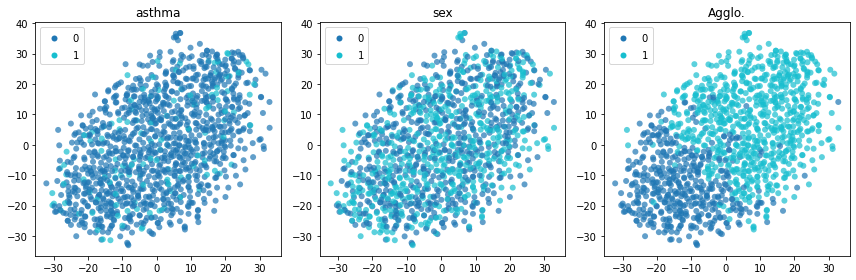

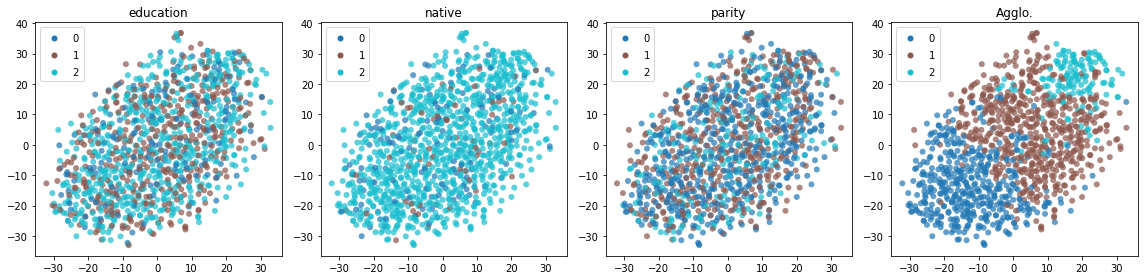

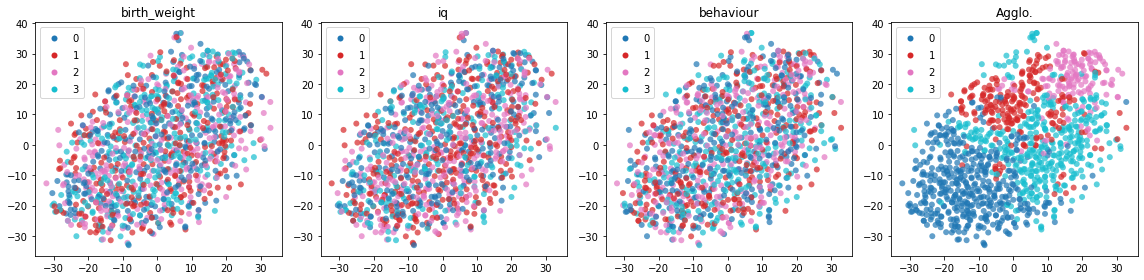

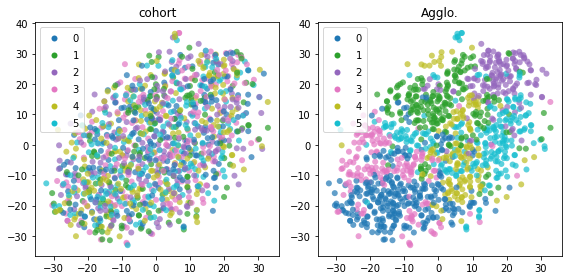

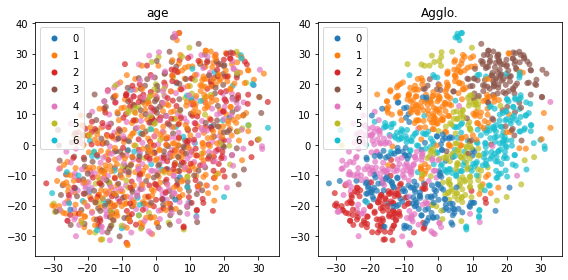

In [14]:
clust_method = "Agglo."

for k in categorical_variables.keys():
    # Compute cluster assignments
    cluster_labels_ = hierarchy.cut_tree(hier, n_clusters=k).squeeze()
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})

    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

# PCA

In [15]:
# Find the number of PCs to explain 0.8 of the variance:
pca = PCA(n_components=0.8)
pca.fit(metabol_exprs)

z_pca = pca.transform(metabol_exprs)

# Number of PCs:
pca.n_components_

36

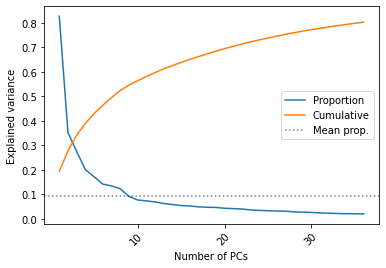

In [16]:
plt.plot(np.arange(0, pca.n_components_), pca.explained_variance_, label="Proportion")
plt.plot(np.arange(0, pca.n_components_), np.cumsum(pca.explained_variance_ratio_), label="Cumulative")
plt.axhline(y = np.mean(pca.explained_variance_), color='black', linestyle='dotted', alpha=0.5, label="Mean prop.")
plt.xticks(np.arange(9, pca.n_components_, 10), np.arange(10, pca.n_components_+1, 10), rotation=45, rotation_mode="anchor", ha='right')
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance');
plt.legend();

## K-means

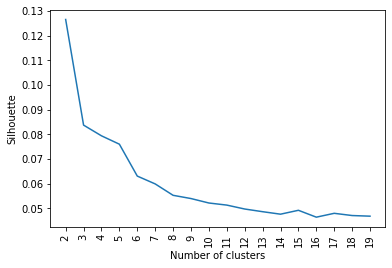

In [20]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(z_pca)
    sils.append(sklearn.metrics.silhouette_score(z_pca, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

In [17]:
tsne = TSNE(n_components=2, init='pca')
z_pca_tsne = tsne.fit_transform(z_pca)

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.127']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.127']
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.084']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.084']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.084']
birth_weight ['Acc: 0.266', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.080']
iq ['Acc: 0.295', 'ARI: -0.001', 'AMI: -0.000', 'Sil: 0.080']
behaviour ['Acc: 0.266', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.080']
cohort ['Acc: 0.215', 'ARI: 0.002', 'AMI: 0.002', 'Sil: 0.063']
age ['Acc: 0.319', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.058']


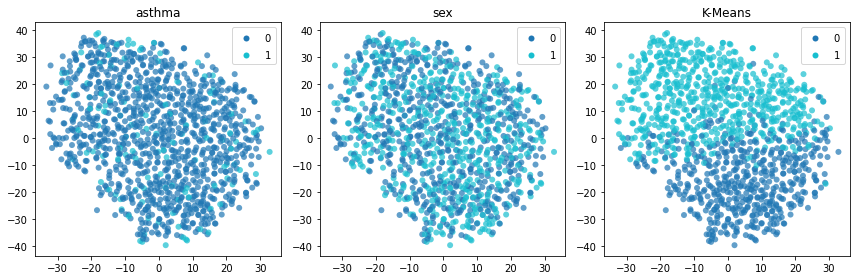

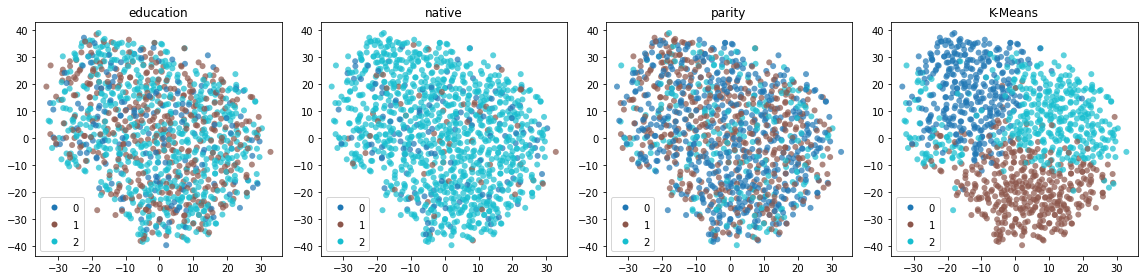

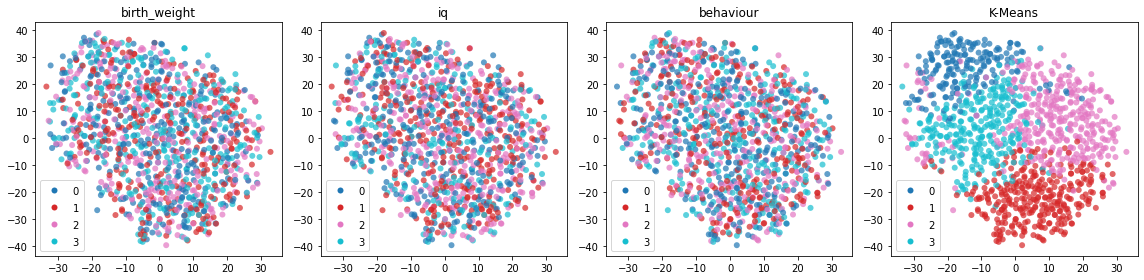

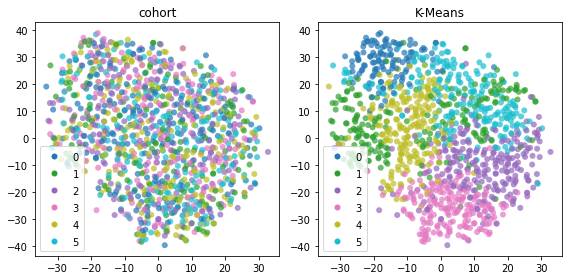

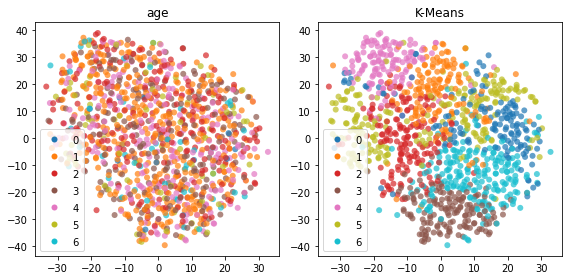

In [18]:
rl_method = "PCA"
clust_method = "K-Means"
data = z_pca
tsne_data = z_pca_tsne

for k in categorical_variables.keys():
    # Compute cluster assignments
    kmeans = KMeans(n_clusters=k, n_init=30)
    cluster_labels_ = kmeans.fit_predict(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})

    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

## GMM

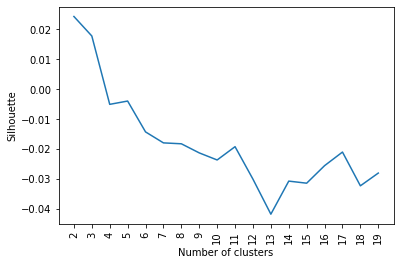

In [23]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=30)
    labels = gmm.fit_predict(z_pca)
    sils.append(sklearn.metrics.silhouette_score(z_pca, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

In [ ]:
clust_method = "GMM"

for k in categorical_variables.keys():
    # Compute cluster assignments
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=30)
    cluster_labels_ = gmm.fit_predict(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})

    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.024']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.024']
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.017']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.017']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.017']
birth_weight ['Acc: 0.281', 'ARI: 0.000', 'AMI: 0.000', 'Sil: -0.005']
iq ['Acc: 0.323', 'ARI: 0.005', 'AMI: 0.006', 'Sil: -0.005']
behaviour ['Acc: 0.277', 'ARI: 0.002', 'AMI: 0.003', 'Sil: -0.005']
cohort ['Acc: 0.201', 'ARI: 0.001', 'AMI: -0.001', 'Sil: -0.018']


## Agglomerative

In [ ]:
pca_hier = hierarchy.linkage(z_pca, method='ward', metric="euclidean")

plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z=pca_hier, p=20, truncate_mode='lastp')
plt.show()

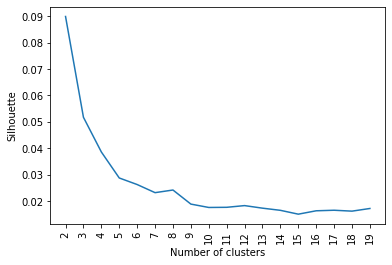

In [26]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    labels = hierarchy.cut_tree(pca_hier, n_clusters=k).squeeze()
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

In [ ]:
clust_method = "Agglo."

for k in categorical_variables.keys():
    # Compute cluster assignments
    cluster_labels_ = hierarchy.cut_tree(pca_hier, n_clusters=k).squeeze()
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})

    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

# Results

## Metrics

In [ ]:
results = pd.DataFrame(results)
# Save the ametrics on a CSV file
results.to_csv("results/metrics_classic.csv", index=False)

results_mean = results.set_index(["rl_method","clust_method"]).groupby(level=[0,1]).mean()
results_mean = results_mean.iloc[:,1:]
results_mean.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

In [ ]:
results.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

There is no match between any of the clusters found and the categorical data. The high accuracy values on the variables "asthma" and "native" are due to there being a groups which contains the majority of the observations, so a random assignment would also get a high accuracy.

## Compare assignments

In [ ]:
labels = pd.DataFrame([d['labels'] for d in cluster_labels])
methods = pd.DataFrame(cluster_labels).loc[:,('rl_method', 'clust_method', 'n_clusters')]
cluster_labels_df = pd.concat((methods, labels), axis=1)

# Save the assignments on a CSV file
pd.DataFrame(cluster_labels_df).to_csv("results/assign_classic.csv", index=False)

In [ ]:
for k in categorical_variables.keys():
    clusters = cluster_labels_df[cluster_labels_df.n_clusters==k]
    show_labels = {clusters.rl_method[i] + " - " + clusters.clust_method[i]: clusters.loc[i,0:] for i in clusters.index}
    draw_multiple_labels(z_pca_tsne, show_labels, max_cols=3, subplot_size=(3,3), alpha=0.6)

There seems to be a lot of overlaping between the found clusters with the different methods, with the exception of "PCA -  GMM", which finds a unique structure.